In [ ]:
### Finding optimal Learning Rate range

In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()



############ Load data

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from functions_dataProcessing import *

set_x,set_y = readXYfromDisk(noOfFiles=20,folder="../data/Train") #Training data
# test_set_x,test_set_y = readXYfromDisk(noOfFiles=1,folder='../data/Test') 

set_y[set_y == 1] = 0
set_y[set_y == 2] = 1

# test_set_y[test_set_y == 1] = 0
# test_set_y[test_set_y == 2] = 1

IMG_SIZE = 128


## Medium - Adam

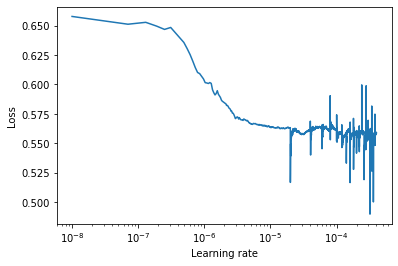

In [9]:

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),   
    tf.keras.layers.Dense(512, activation='relu'),    
    tf.keras.layers.Dense(512, activation='relu'),    
    tf.keras.layers.Dense(256, activation='relu'),    
    tf.keras.layers.Dense(256, activation='relu'),    
    # tf.keras.layers.Dense(128, activation='relu'),        
    # tf.keras.layers.Dense(128, activation='relu'),        
    # tf.keras.layers.Dense(64, activation='relu'),        
    # tf.keras.layers.Dense(64, activation='relu'),        
    # tf.keras.layers.Dense(16, activation='relu'),        
    # tf.keras.layers.Dense(16, activation='relu'),        
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-8)
                ,loss=tf.keras.losses.binary_crossentropy)
                # ,metrics=[METRICS])

#Call back
lr_finder = LRFinder(min_lr=1e-8, 
                max_lr=1e-4, 
                steps_per_epoch=np.ceil(set_x.shape[0]/256), 
                epochs=5
                )

history = model.fit(set_x, set_y
                    ,batch_size = 256
                    ,epochs=20
                    ,verbose=0
                    # ,validation_data=(test_set_x,test_set_y)
                    ,workers=6
                    ,use_multiprocessing=True
                    ,callbacks=[lr_finder]
                    )

lr_finder.plot_loss()



## Medium - Adam - Regularisation

X Shape :  (85064, 128, 128, 3) Memory size is : 3987.375 Mb Y Shape:  (85064,)
Values, counts, Avg Performance :  [0 1 2] [44005 20023 21036] [0.51731637 0.23538747 0.24729615]


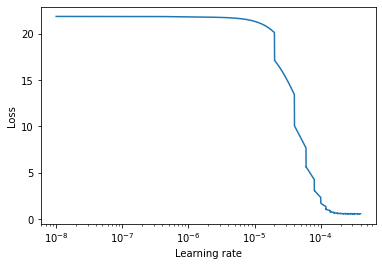

In [2]:


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),   
    tf.keras.layers.Dense(512, activation='relu'
                            ,kernel_regularizer=tf.keras.regularizers.l2()),    
    tf.keras.layers.Dense(512, activation='relu'
                            ,kernel_regularizer=tf.keras.regularizers.l2()),    
    tf.keras.layers.Dense(256, activation='relu'
                            ,kernel_regularizer=tf.keras.regularizers.l2()),    
    tf.keras.layers.Dense(256, activation='relu'
                            ,kernel_regularizer=tf.keras.regularizers.l2()),    
    # tf.keras.layers.Dense(128, activation='relu'),        
    # tf.keras.layers.Dense(128, activation='relu'),        
    # tf.keras.layers.Dense(64, activation='relu'),        
    # tf.keras.layers.Dense(64, activation='relu'),        
    # tf.keras.layers.Dense(16, activation='relu'),        
    # tf.keras.layers.Dense(16, activation='relu'),        
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-8)
                ,loss=tf.keras.losses.binary_crossentropy)
                # ,metrics=[METRICS])

#Call back
lr_finder = LRFinder(min_lr=1e-8, 
                max_lr=1e-4, 
                steps_per_epoch=np.ceil(set_x.shape[0]/256), 
                epochs=5
                )

history = model.fit(set_x, set_y
                    ,batch_size = 256
                    ,epochs=20
                    ,verbose=0
                    # ,validation_data=(test_set_x,test_set_y)
                    ,workers=6
                    ,use_multiprocessing=True
                    ,callbacks=[lr_finder]
                    )

lr_finder.plot_loss()




## Large - Adam

X Shape :  (85064, 128, 128, 3) Memory size is : 3987.375 Mb Y Shape:  (85064,)
Values, counts, Avg Performance :  [0 1 2] [44005 20023 21036] [0.51731637 0.23538747 0.24729615]


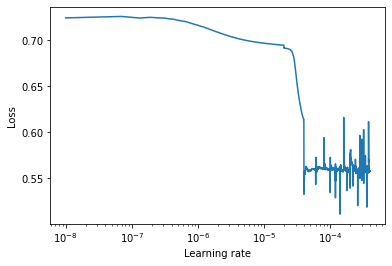

In [2]:

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),   
    tf.keras.layers.Dense(512, activation='relu'),    
    tf.keras.layers.Dense(512, activation='relu'),    
    tf.keras.layers.Dense(256, activation='relu'),    
    tf.keras.layers.Dense(256, activation='relu'),    
    tf.keras.layers.Dense(128, activation='relu'),        
    tf.keras.layers.Dense(128, activation='relu'),        
    tf.keras.layers.Dense(64, activation='relu'),        
    tf.keras.layers.Dense(64, activation='relu'),        
    tf.keras.layers.Dense(16, activation='relu'),        
    tf.keras.layers.Dense(16, activation='relu'),        
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-8)
                ,loss=tf.keras.losses.binary_crossentropy)
                # ,metrics=[METRICS])

#Call back
lr_finder = LRFinder(min_lr=1e-8, 
                max_lr=1e-4, 
                steps_per_epoch=np.ceil(set_x.shape[0]/256), 
                epochs=5
                )

history = model.fit(set_x, set_y
                    ,batch_size = 256
                    ,epochs=20
                    ,verbose=0
                    # ,validation_data=(test_set_x,test_set_y)
                    ,workers=6
                    ,use_multiprocessing=True
                    ,callbacks=[lr_finder]
                    )

lr_finder.plot_loss()

## Medium - RMSProp

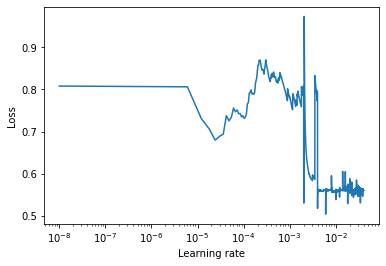

In [4]:

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),   
    tf.keras.layers.Dense(512, activation='relu'),    
    tf.keras.layers.Dense(512, activation='relu'),    
    tf.keras.layers.Dense(256, activation='relu'),    
    tf.keras.layers.Dense(256, activation='relu'),    
    # tf.keras.layers.Dense(128, activation='relu'),        
    # tf.keras.layers.Dense(128, activation='relu'),        
    # tf.keras.layers.Dense(64, activation='relu'),        
    # tf.keras.layers.Dense(64, activation='relu'),        
    # tf.keras.layers.Dense(16, activation='relu'),        
    # tf.keras.layers.Dense(16, activation='relu'),        
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-7)
                ,loss=tf.keras.losses.binary_crossentropy)
                # ,metrics=[METRICS])

#Call back
lr_finder = LRFinder(min_lr=1e-8, 
                max_lr=1e-2, 
                steps_per_epoch=np.ceil(set_x.shape[0]/256), 
                epochs=5
                )

history = model.fit(set_x, set_y
                    ,batch_size = 256
                    ,epochs=20
                    ,verbose=0
                    # ,validation_data=(test_set_x,test_set_y)
                    ,workers=6
                    ,use_multiprocessing=True
                    ,callbacks=[lr_finder]
                    )

lr_finder.plot_loss()



## Medium - RMSProp - Regularisation

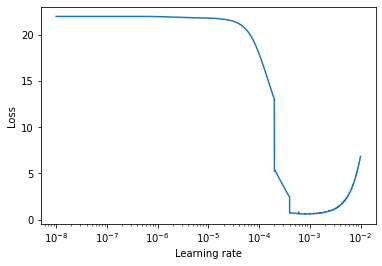

In [6]:


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),   
    tf.keras.layers.Dense(512, activation='relu'
                            ,kernel_regularizer=tf.keras.regularizers.l2()),    
    tf.keras.layers.Dense(512, activation='relu'
                            ,kernel_regularizer=tf.keras.regularizers.l2()),    
    tf.keras.layers.Dense(256, activation='relu'
                            ,kernel_regularizer=tf.keras.regularizers.l2()),    
    tf.keras.layers.Dense(256, activation='relu'
                            ,kernel_regularizer=tf.keras.regularizers.l2()),    
    # tf.keras.layers.Dense(128, activation='relu'),        
    # tf.keras.layers.Dense(128, activation='relu'),        
    # tf.keras.layers.Dense(64, activation='relu'),        
    # tf.keras.layers.Dense(64, activation='relu'),        
    # tf.keras.layers.Dense(16, activation='relu'),        
    # tf.keras.layers.Dense(16, activation='relu'),        
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-8)
                ,loss=tf.keras.losses.binary_crossentropy)
                # ,metrics=[METRICS])

#Call back
lr_finder = LRFinder(min_lr=1e-8, 
                max_lr=1e-3, 
                steps_per_epoch=np.ceil(set_x.shape[0]/256), 
                epochs=5
                )

history = model.fit(set_x, set_y
                    ,batch_size = 256
                    ,epochs=50
                    ,verbose=0
                    # ,validation_data=(test_set_x,test_set_y)
                    ,workers=6
                    ,use_multiprocessing=True
                    ,callbacks=[lr_finder]
                    )

lr_finder.plot_loss()




## Large - RMSProp

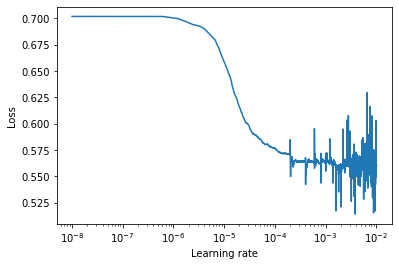

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),   
    tf.keras.layers.Dense(512, activation='relu'),    
    tf.keras.layers.Dense(512, activation='relu'),    
    tf.keras.layers.Dense(256, activation='relu'),    
    tf.keras.layers.Dense(256, activation='relu'),    
    tf.keras.layers.Dense(128, activation='relu'),        
    tf.keras.layers.Dense(128, activation='relu'),        
    tf.keras.layers.Dense(64, activation='relu'),        
    tf.keras.layers.Dense(64, activation='relu'),        
    tf.keras.layers.Dense(16, activation='relu'),        
    tf.keras.layers.Dense(16, activation='relu'),        
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-7)
                ,loss=tf.keras.losses.binary_crossentropy)
                # ,metrics=[METRICS])

#Call back
lr_finder = LRFinder(min_lr=1e-8, 
                max_lr=1e-3, 
                steps_per_epoch=np.ceil(set_x.shape[0]/256), 
                epochs=5
                )

history = model.fit(set_x, set_y
                    ,batch_size = 256
                    ,epochs=50
                    ,verbose=0
                    # ,validation_data=(test_set_x,test_set_y)
                    ,workers=6
                    ,use_multiprocessing=True
                    ,callbacks=[lr_finder]
                    )

lr_finder.plot_loss()